### Goals:
- Extract features from the photographs taken with a camera setup on the vehicle.
- Use the extracted features to find matches between the features in different photographs.
- Use the found matches to estimate the camera motion between subsequent photographs.
- Use the estimated camera motion to build the vehicle trajectory.

Coursera: https://www.coursera.org/learn/visual-perception-self-driving-cars/ungradedLab/TX6tn/practice-assignment-applying-stereo-depth-to-a-driving-scenario/lab?path=%2Fnotebooks%2Fmodule2%2FVisual%2520Odometry%2520for%2520Localization%2520in%2520Autonomous%2520Driving.ipynb 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from m2bk import *

## Loading and Visualizing the Data

The dataset handler contains 52 data frames. Each frame contains an RGB image and a depth map taken with a setup on the vehicle and a grayscale version of the RGB image which will be used for computation. Furthermore, camera calibration matrix K is also provided in the dataset handler

The frame content can be accessed by using `images`, `images_rgb`, `depth_maps` attributes of the dataset handler object along with the index of the requested frame. See how to access the images below

In [ ]:
# DONT RUN THIS 

# Self-Driving Example Dataset -- unpushed
dataset_handler = DatasetHandler()
k = np.array([[640, 0, 640],
              [0, 480, 480],
              [0,   0,   1]], dtype=np.float32)

# LOADING IMAGES FROM GIVEN DATASET
# Show RGB Image
image_rgb = dataset_handler.images_rgb[0]
plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image_rgb)
plt.show()

# Show Depth Map
i = 0
depth = dataset_handler.depth_maps[i]
plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(depth, cmap='jet')
plt.show()

print("Depth map shape: {0}".format(depth.shape))

v, u = depth.shape
depth_val = depth[v-1, u-1]
print("Depth value of the very bottom-right pixel of depth map {0} is {1:0.3f}".format(i, depth_val))

# Load Camera Calibration Matrix
dataset_handler.k

### The dataset I am using is in `/my_data`
- contains 5 images of my room in BGR color format

In [3]:
# Neato Camera Calibration Matrix
k = np.array([[500.68763, 0.0, 378.6717,],
              [0.0, 501.1204 , 207.83452,],
              [0.0, 0.0, 1.0]], dtype=np.float32)

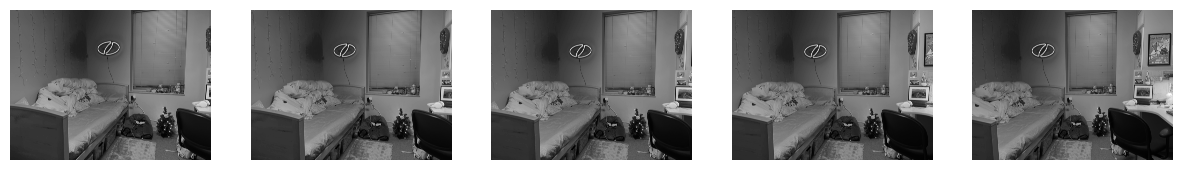

In [4]:
# Make image dataset

dataset_RGB = []
dataset_GRAY = []
for i in range(1, 6):
    filename = "my_data/frame_" + str(i) + ".jpeg"

    # Make a dataset of RGB images
    img_RGB = cv2.imread(filename)
    img_RGB = cv2.cvtColor(img_RGB, cv2.COLOR_BGR2RGB )
    dataset_RGB.append(img_RGB)

    # Make a dataset of RGB images
    img = cv2.imread(filename,0)
    dataset_GRAY.append(img)


# Display images
fig, axes = plt.subplots(1, len(dataset_RGB), figsize=(15, 5))
for ax, img in zip(axes, dataset_GRAY):
    # plt.figure(figsize=(8, 6), dpi=100)
    ax.imshow(img, cmap='gray')
    ax.axis('off')  # Hide axes for better visualization

plt.show()


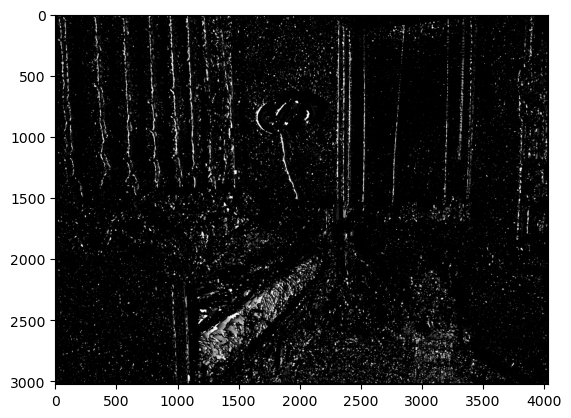

In [5]:
# DISPARITY MAP FROM TWO IMAGES -- STEREO CAMERA IMPLEMENTATION?

# read two input images as grayscale images
imgL = cv2.imread('my_data/frame_1.jpeg',0)
imgR = cv2.imread('my_data/frame_2.jpeg',0)

# Initiate and StereoBM object
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)

# compute the disparity map
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'gray')
plt.show()
# disparity.shape


In [6]:
print(disparity)

[[-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 ...
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]]


In [ ]:
# GETTING A DEPTH MAP
    # (B is the baseline, the distance between the cams, and f the focal length)
    # depth = baseline * focal / disparity


# QUESTIONS
#   - What the matrix shape should be in order to compute a depth map?
#   - How will I know the baseline btwn two images? Will we use the Neato internal odom for this?
#       - then if I use the Neato odom, does this mean we won't need a stereo camera
#   - If we want a depth map for each frame/image, but to determine the depth map, we compare current frame to previous frame. How will that happen for the last index?


baseline = 0.1      # estimate of distance btwn images

my_depth_map = baseline * k / disparity


ValueError: operands could not be broadcast together with shapes (3,3) (3024,4032) 

## 1 - Feature Extraction from Each Image in Dataset

__Task:__ Implement feature extraction for each image in the dataset with the function you wrote in the above section.

- Make sure you understand the structure of the keypoint descriptor object, this will be very useful for your further tasks. You might find [OpenCV: Keypoint Class Description](https://docs.opencv.org/3.4.3/d2/d29/classcv_1_1KeyPoint.html) handy. 

- Make sure you understand the image coordinate system, namely the origin location and axis directions.

- We provide you with a function to visualise the features detected. Run the last 2 cells in section 1.1 to view.

- Optional: Try to extract features with different descriptors such as SIFT, ORB, SURF and BRIEF. You can also try using detectors such as Harris corners or FAST and pairing them with a descriptor. Lastly, try changing parameters of the algorithms. Do you see the difference in various approaches? You might find this link useful: [OpenCV:Feature Detection and Description](https://docs.opencv.org/3.4.3/db/d27/tutorial_py_table_of_contents_feature2d.html).

In [10]:
def extract_features_dataset(images):
    """
    Find keypoints and descriptors for each image in the dataset

    Arguments:
    images -- a list of grayscale images

    Returns:
    kp_list -- a list of keypoints for each image in images
    des_list -- a list of descriptors for each image in images
    
    """
    kp_list = []
    des_list = []

    # Create SIFT object
    sift = cv2.xfeatures2d.SIFT_create()
    
    for img in images:
        # Detect keypoints and compute descriptors
        kp, des = sift.detectAndCompute(img, None)
        kp_list.append(kp)
        des_list.append(des)
    
    return kp_list, des_list

In [11]:
# FOR SINGLE IMAGE
# print(kp[1].pt)
# print(f"Number of features detected in image 1: {len(kp)}\n")

# print(f"Coordinates of the first keypoint in image 1: {str(kp[0].pt)}")


# images = dataset_handler.images
images = dataset_GRAY # NOT IN GRAYSCALE
kp_list, des_list = extract_features_dataset(images)

i = 0
print("Number of features detected in frame {0}: {1}".format(i, len(kp_list[i])))
print("Coordinates of the first keypoint in frame {0}: {1}\n".format(i, str(kp_list[i][0].pt)))

# Remember that the length of the returned by dataset_handler lists should be the same as the length of the image array
print("Length of images array: {0}".format(len(images)))

[ WARN:0@63.654] global shadow_sift.hpp:13 SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


Number of features detected in frame 0: 36518
Coordinates of the first keypoint in frame 0: (96.94774627685547, 1896.7225341796875)

Length of images array: 5


In [12]:
def visualize_features(image, kp):
    """
    Visualize extracted features in the image

    Arguments:
    image -- a grayscale image
    kp -- list of the extracted keypoints

    Returns:
    """
    display = cv2.drawKeypoints(image, kp, None, color=(0,255,0), flags=0)
    plt.imshow(display)
    plt.show()

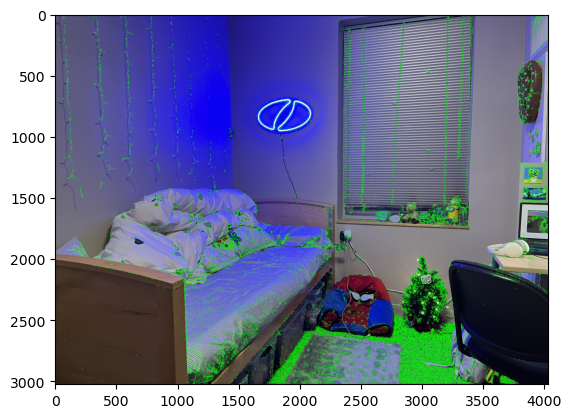

In [14]:
i = 1
visualize_features(dataset_RGB[i], kp_list[i])

## 2 - Feature Matching From Each Image in Dataset [FILTERED]

__Task:__ Implement feature matching for each subsequent image pair in the dataset with the function you wrote in the above section.

Optional: Implement match filtering by thresholding the distance for each subsequent image pair. This might be useful for improving your overall trajectory estimation results. Recall that you have an option of specifying the number best matches to be returned by the matcher.

In [15]:
def match_features_dataset(des_list, dist_threshold=0.6):
    """
    Match features for each subsequent image pair in the dataset

    Arguments:
    des_list -- a list of descriptors for each image in the dataset
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    matches_list -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
               
    """
    matches_list = []

    # Brute Force matching
    bf = cv2.BFMatcher()
    
    # matches features in image i and i+1
    for i in range(len(des_list)-1):
        # Set empty list for each image
        lst = []

        # BFMatcher.knnMatch() to get k best matches. In this example, we will take k=2 so that we can apply ratio test explained by D.Lowe in his paper.
        match = bf.knnMatch(des_list[i], des_list[i+1],k=2)

        # Filter through matches
        for m,n in match:
            if m.distance < (dist_threshold * n.distance):
                lst.append([m])
        matches_list.append(lst)
                       
    return matches_list

In [17]:
matches = match_features_dataset(des_list)

i = 0
print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(matches[i])))

Number of features matched in frames 0 and 1: 7698


In [36]:
def visualize_matches(image1, kp1, image2, kp2, match, outImg):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """    
    # draw lines to match the features 
    image_matches = cv2.drawMatchesKnn(image1,kp1,image2,kp2, outImg, match,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    return image_matches

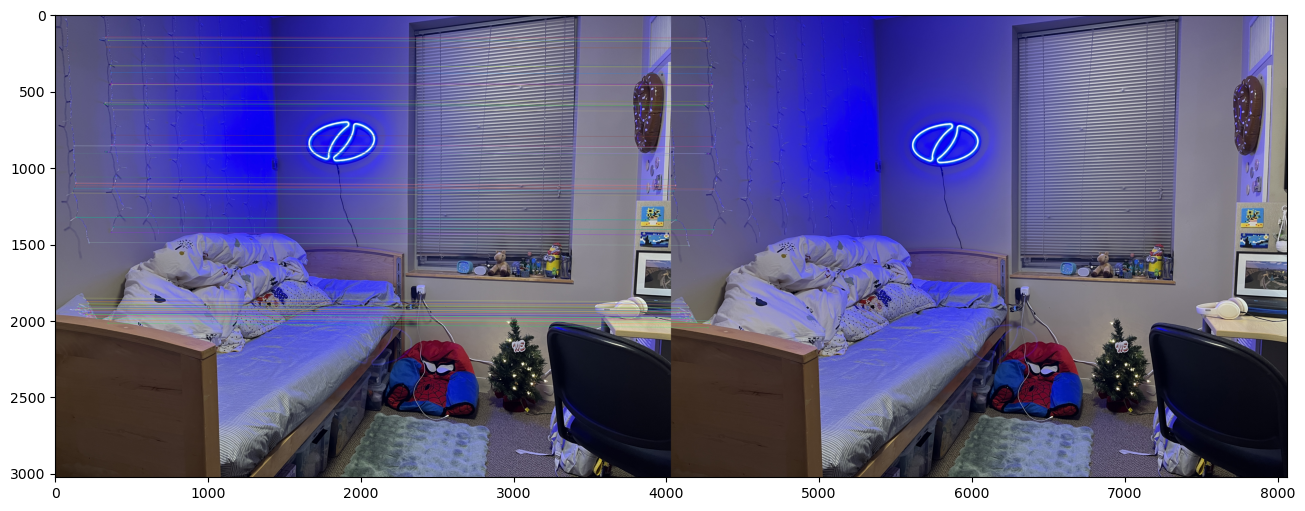

In [37]:
# Visualize n first matches
n = 100     # None to view all matches

i = 1

image1 = dataset_RGB[i]
image2 = dataset_RGB[i+1]

# keypoint 
kp1 = kp_list[i]
kp2 = kp_list[i+1]

# descriptors
des1 = des_list[i]
des2 = des_list[i+1]

# match = match_features_dataset(des_list)

outImg = np.empty((1,1))
    
# print(len(match))
image_matches = visualize_matches(image1, kp1, image2, kp2, outImg, matches[i][:n])
plt.figure(figsize=(16, 6), dpi=100)
plt.imshow(image_matches)
plt.show()


# THIS IS WHERE i AM STUCK ON RIGHT NOW -- REQUIRES DEPTH MAP

# 3 - Trajectory Estimation
At this point you have everything to perform visual odometry for the autonomous vehicle. In this section you will incrementally estimate the pose of the vehicle by examining the changes that motion induces on the images of its onboard camera.

## 3.1 - Estimating Camera Motion between a Pair of Images
__Task:__ Implement camera motion estimation from a pair of images. You can use the motion estimation algorithm covered in the lecture materials, namely Perspective-n-Point (PnP), as well as Essential Matrix Decomposition.

If you decide to use PnP, you will need depth maps of frame and they are provided with the dataset handler. Check out Section 0 of this assignment to recall how to access them if you need. As this method has been covered in the course, review the lecture materials if need be.
If you decide to use Essential Matrix Decomposition, more information about this method can be found in [Wikipedia: Determining R and t from E](https://en.wikipedia.org/wiki/Essential_matrix).
More information on both approaches implementation can be found in [OpenCV: Camera Calibration and 3D Reconstruction](https://docs.opencv.org/3.4.3/d9/d0c/group__calib3d.html). Specifically, you might be interested in Detailed Description section of [OpenCV: Camera Calibration and 3D Reconstruction](https://docs.opencv.org/3.4.3/d9/d0c/group__calib3d.html) as it explains the connection between the 3D world coordinate system and the 2D image coordinate system.

Optional: Implement camera motion estimation with PnP, PnP with RANSAC and Essential Matrix Decomposition. Check out how filtering matches by distance changes estimated camera movement. Do you see the difference in various approaches?

In [73]:
def estimate_motion(match, kp1, kp2, k, depth1):
    """
    Estimate camera motion from a pair of subsequent image frames

    Arguments:
    match -- list of matched features from the pair of images
    kp1 -- list of the keypoints in the first image
    kp2 -- list of the keypoints in the second image
    k -- camera calibration matrix 
    
    Optional arguments:
    depth1 -- a depth map of the first frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    rmat -- recovered 3x3 rotation numpy matrix
    tvec -- recovered 3x1 translation numpy vector
    image1_points -- a list of selected match coordinates in the first image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
    image2_points -- a list of selected match coordinates in the second image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
               
    """

    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    image1_points = []
    image2_points = []
    
    objectpoints = []

    # Iterate through the matched features
    for m in match:
        # Get the pixel coordinates of features f[k - 1] and f[k]
        u1, v1 = kp1[m[0].queryIdx].pt
        # print(f"u1 is {u1}")
        # print(f"v1 is {v1}")
        u2, v2 = kp2[m[0].trainIdx].pt

        # Get the scale of features f[k - 1] from the depth map
        s = depth1[int(v1), int(u1)]

        # Check for valid scale values
        if s < 1000:
            # Transform pixel coordinates to camera coordinates using the pinhole camera model
            p_c = np.linalg.inv(k) @ (s * np.array([u1, v1, 1]))

            # Save the results
            image1_points.append([u1, v1])
            image2_points.append([u2, v2])
            objectpoints.append(p_c)

    # Convert lists to numpy arrays
    objectpoints = np.vstack(objectpoints)
    imagepoints = np.array(image2_points)

    # Determine the camera pose from the Perspective-n-Point solution using the RANSAC scheme
    _, rvec, tvec, _ = cv2.solvePnPRansac(objectpoints, imagepoints, k, None)

    # Convert rotation vector to rotation matrix
    rmat, _ = cv2.Rodrigues(rvec)
    
    return rmat, tvec, image1_points, image2_points


In [ ]:
i = 0
match = matches[i] # get matches btwn img0 and img1
kp1 = kp_list[i] # keypoints of img0
kp2 = kp_list[i+1] # keypoints of img1
# k = dataset_handler.k
depth = dataset_handler.depth_maps[i]

rmat, tvec, image1_points, image2_points = estimate_motion(match, kp1, kp2, k, depth1=depth)

print("Estimated rotation:\n {0}".format(rmat))
print("Estimated translation:\n {0}".format(tvec))

u1 is 6.653790473937988
v1 is 439.0070495605469
u1 is 15.888962745666504
v1 is 449.28143310546875
u1 is 20.021209716796875
v1 is 485.1279602050781
u1 is 20.11078453063965
v1 is 544.8843994140625
u1 is 23.41149139404297
v1 is 481.2740783691406
u1 is 23.456432342529297
v1 is 415.9894714355469
u1 is 27.51154899597168
v1 is 446.7978210449219
u1 is 27.64078140258789
v1 is 492.6021423339844
u1 is 28.807218551635742
v1 is 456.6022033691406
u1 is 30.617326736450195
v1 is 442.333984375
u1 is 39.17690658569336
v1 is 388.3407897949219
u1 is 43.992828369140625
v1 is 450.08770751953125
u1 is 44.534671783447266
v1 is 520.5007934570312
u1 is 44.86848831176758
v1 is 507.65789794921875
u1 is 47.857025146484375
v1 is 404.0323181152344
u1 is 49.399566650390625
v1 is 450.47235107421875
u1 is 60.050743103027344
v1 is 491.29180908203125
u1 is 60.58589553833008
v1 is 508.56634521484375
u1 is 66.38308715820312
v1 is 422.7460021972656
u1 is 68.17193603515625
v1 is 456.3825988769531
u1 is 70.69418334960938
v1 i

__Expected Output Format:__

Make sure that your estimated rotation matrix and translation vector are in the same format as the given initial values

rmat = np.eye(3)
tvec = np.zeros((3, 1))

print("Initial rotation:\n {0}".format(rmat))
print("Initial translation:\n {0}".format(tvec))
Initial rotation:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Initial translation:
 [[0.]
 [0.]
 [0.]]

__Camera Movement Visualization:__ You can use `visualize_camera_movement` that is provided to you. This function visualizes final image matches from an image pair connected with an arrow corresponding to direction of camera movement (when `is_show_img_after_mov = False`). The function description:

Arguments:

`image1` - the first image in a matched image pair (RGB or grayscale)

`image1_points` - a list of selected match coordinates in the first image. image1_points[i] = [x, y], where x and y are coordinates of the i-th match in the image coordinate system

`image2` - the second image in a matched image pair (RGB or grayscale)

`image2_points` - a list of selected match coordinates in the second image. image1_points[i] = [x, y], where x and y are coordinates of the i-th match in the image coordinate system

`is_show_img_after_mov` -- a boolean variable, controling the output (read image_move description for more info) 

Returns:

`image_move` -- an image with the visualization. When `is_show_img_after_mov=False` then the image points from both images are visualized on the first image. Otherwise, the image points from the second image only are visualized on the second image

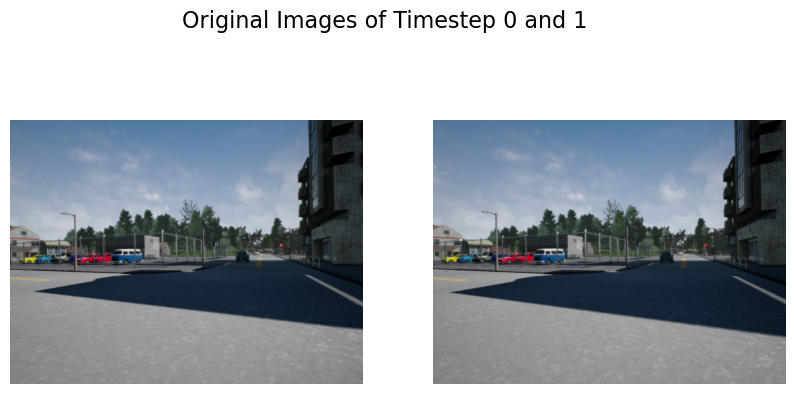

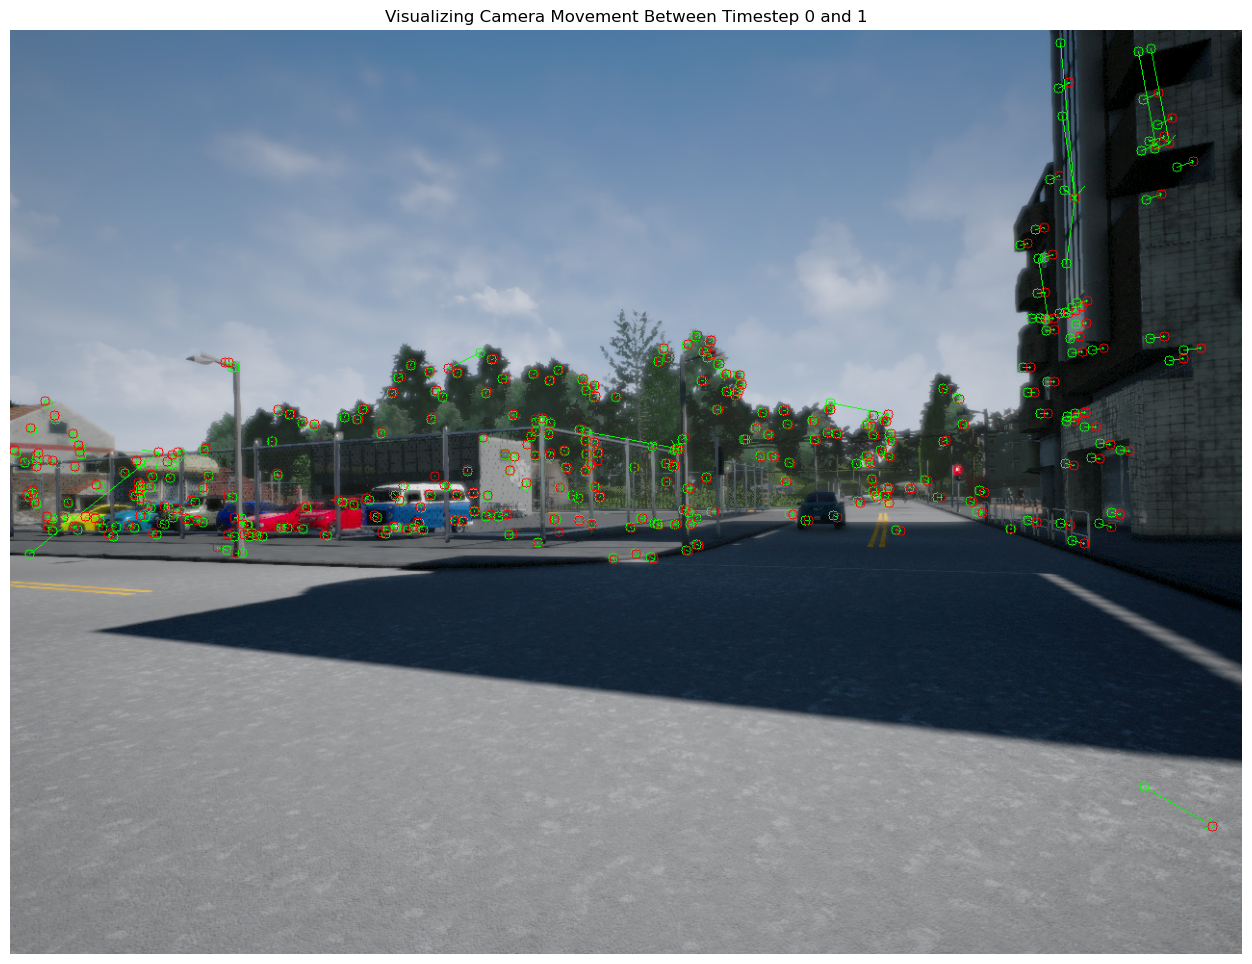

In [69]:
i=0
image1  = dataset_handler.images_rgb[i]
image2 = dataset_handler.images_rgb[i+1]

# Showing original images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image
axes[0].imshow(image1)
axes[0].axis('off')  # Turn off axis if not needed

# Display the second image
axes[1].imshow(image2)
axes[1].axis('off')  # Turn off axis if not needed

# Set a title for the entire figure
fig.suptitle(f"Original Images of Timestep {i} and {i+1}", fontsize=16)

image_move = visualize_camera_movement(image1, image1_points, image2, image2_points, is_show_img_after_move=False)
plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(image_move)
plt.axis('off')
plt.title(f"Visualizing Camera Movement Between Timestep {i} and {i+1}")
plt.show()

## 3.2 - Camera Trajectory Estimation

__Task:__ Implement camera trajectory estimation with visual odometry. More specifically, implement camera motion estimation for each subsequent image pair in the dataset with the function you wrote in the above section.

Note: Do not forget that the image pairs are not independent one to each other. i-th and (i + 1)-th image pairs have an image in common

In [70]:
def estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps):
    """
    Estimate complete camera trajectory from subsequent image pairs

    Arguments:
    estimate_motion -- a function which estimates camera motion from a pair of subsequent image frames
    matches -- list of matches for each subsequent image pair in the dataset. 
               Each matches[i] is a list of matched features from images i and i + 1
    des_list -- a list of keypoints for each image in the dataset
    k -- camera calibration matrix 
    
    Optional arguments:
    depth_maps -- a list of depth maps for each frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    trajectory -- a 3xlen numpy array of the camera locations, where len is the lenght of the list of images and   
                  trajectory[:, i] is a 3x1 numpy vector, such as:
                  
                  trajectory[:, i][0] - is X coordinate of the i-th location
                      trajectory[0].append(x)
                  trajectory[:, i][1] - is Y coordinate of the i-th location
                      trajectory[0].append(y)
                  trajectory[:, i][2] - is Z coordinate of the i-th location
                  
                  * Consider that the origin of your trajectory cordinate system is located at the camera position 
                  when the first image (the one with index 0) was taken. The first camera location (index = 0) is geven 
                  at the initialization of this function

    """
#     trajectory = np.zeros((3, 1))
    
#     for i in range(len(matches)):
#         rmat, tvec, image1_points, image2_points = estimate_motion(matches[i], kp_list[i], kp_list[i + 1], k)
#         tvec = np.array(tvec)
#         prev_traj = np.array(trajectory[:, i].reshape(-1, 1))
#         camera_position = tvec - prev_traj
#         trajectory = np.concatenate((trajectory, camera_position), axis=1)
#     return trajectory

    # Create variables for computation
    trajectory = np.zeros((3, len(matches) + 1))
    robot_pose = np.zeros((len(matches) + 1, 4, 4))

    # Initialize camera pose
    robot_pose[0] = np.eye(4)

    # Iterate through the matched features
    for i in range(len(matches)):
        # Estimate camera motion between a pair of images
        rmat, tvec, image1_points, image2_points = estimate_motion(matches[i], kp_list[i], kp_list[i + 1], k, depth_maps)

        # Save camera movement visualization
        if save:
            image = visualize_camera_movement(dataset_handler.images_rgb[i], image1_points, dataset_handler.images_rgb[i + 1], image2_points)
            plt.imsave('{}/frame_{:02d}.jpg'.format(save, i), image)

        # Determine current pose from rotation and translation matrices
        current_pose = np.eye(4)
        current_pose[0:3, 0:3] = rmat
        current_pose[0:3, 3] = tvec.T

        # Build the robot's pose from the initial position by multiplying previous and current poses
        robot_pose[i + 1] = robot_pose[i] @ np.linalg.inv(current_pose)

        # Calculate current camera position from origin
        position = robot_pose[i + 1] @ np.array([0., 0., 0., 1.])

        # Build trajectory
        trajectory[:, i + 1] = position[0:3]
        
    return trajectory

In [75]:
depth_maps = dataset_handler.depth_maps
trajectory = estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps)

i = 1
print("Camera location in point {0} is: \n{1}\n".format(i, trajectory[:, [i]]))

# Remember that the length of the returned by trajectory should be the same as the length of the image array
print("Length of trajectory: {0}".format(trajectory.shape[1]))

u1 is 6.653790473937988
v1 is 439.0070495605469


TypeError: list indices must be integers or slices, not tuple